# Dam parametrisation Hanasaki et al 2006 


Based on: 
Hanasaki, N., Kanae, S., & Oki, T. (2006). A reservoir operation scheme for global river routing models. Journal of Hydrology, 327(1–2), 22–41. https://doi.org/10.1016/j.jhydrol.2005.11.011

Inne Vanderkelen -  January 2021


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

secprday=86400

## Load observations

In [12]:
# Load data from Yassin et al 2019
metadata = pd.read_csv('observations/reservoirs_metadata.csv')
metadata.index = metadata['name']

# select reservoir name
reservoir_name = 'Dickson' # possible to replace by: Dickson, Bhumiboi, Waterton, Glen_canyon, Palisades, Tribity, Semione, Sirikit
purpose = metadata.loc[reservoir_name].purpose
max_storage = metadata.loc[reservoir_name].capacity_mcm*10**6

# load observations
fn = 'observations/res_info_out_'+reservoir_name+'.csv'
df = pd.read_csv(fn)
df.index = pd.to_datetime(df.timed)

outflow_obs = df['outflow']
storage_obs = df['stoobs']
inflow = df['inflow']

## Parameters required for Hanasaki
Necessary parameters in MizuRoute per reservoir: 
- reservoir purpose (1)
- max storage (1)
- monthly inflow (12) (maybe possible to log monthly inflow for 5 years + calculate total annual outflow based on this?)
- for irrigation reservoirs: monthly irrigation demand (12) (I think eventually this will be communicated from CLM in coupling?) 

input: 
- (daily) inflow

output: 
- (daily) outflow

In [13]:
# average inflow (Hanasaki uses naturalised inflow)
# tbd how to do in MizuRoute (e.g. log mean monthly inflow inflow of last 20 or 5 years, e.g. Droppers et al., 2020)

# here taken as mean over whole observational period
mean_inflow = inflow.mean() # (m³/s)

mean_inflow_monthly = inflow.groupby([inflow.index.month]).mean() # to adjust for seasonal cycle (m³/s)

# total annual inflow
mean_inflow_total = inflow.mean()* secprday * 365 #[m³/yr]

c = max_storage/mean_inflow_total # if c>0.5 : large reservoir, if c < 0.5: "whitin-a-year" reservoir, if c = 0, reservoir is "run-of-the-river"



In [14]:
print(c)
print(mean_inflow_total)
print(mean_inflow_monthly)

0.18002617156305836
1127613825.4647853
timed
1       8.646143
2       8.588548
3       9.841558
4      18.645710
5      57.964023
6     132.582824
7      59.533733
8      41.274009
9      42.037962
10     27.566028
11     12.102624
12      9.800770
Name: inflow, dtype: float64


In [15]:
# irrigation demand - leave out for now. 
# monthly irrigation demand to the reservoir
demand_irrig_monthly = 0 # [m³/s] 

# mean annual irrigation demand to reservoir (calculated based on last 20 years (Biemans) or 5 years (Droppers et al.) 
demand_irrig_annual = 0 # [m³/s] also possible to include domestic and industrial demand. 



In [16]:
# constants for Hanasaki parametrisation

# how much of total storage is active
alpha = 0.85 # nondimensional constant

# evironmental flow requirement EFR factor (how much of annual inflow is required for release)
# only important for meeting irrgation demands
# Hanasaki uses 0.5, later studies use 0.1 Biemans et al., 2011; Voisin et al., 2013 to avoid excessive releases and increasing irrigation water availability
# Droppers et al calculated erf seperately
erf_factor = 0.1



### Determine start operational year
when monthly inflow < annual average inflow, i.e. start of the release period. 

tbd how to determine this within MizuRoute or take as a parameter for each reservoir?
I think not way to go, would require to have this info for each reservoir

In [17]:
# extract one hydrological year - this can be done more efficiently
inds_recharge = (mean_inflow_monthly>mean_inflow) # recharge months
inds_release = (mean_inflow_monthly<mean_inflow) # release months

ind_first_recharge = np.where(inds_recharge.cumsum()==1)[0].item()
ind_first_release = inds_release[ind_first_recharge:].cumsum()==1

start_month = ind_first_release[ind_first_release == True].index.item()

# reconfigure input year to operational years

start_date = str(inflow.index.year[0])+'-'+str(start_month)+'-01'
inflow = inflow[start_date:]

print(start_date)

2005-10-01


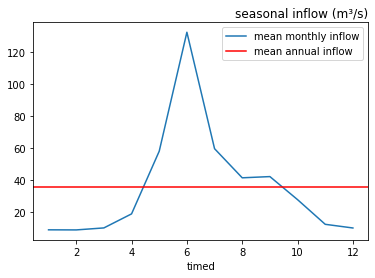

In [18]:
# plot mean outflow cycle
mean_inflow_monthly.plot()
plt.axhline(y=mean_inflow, color = 'r')
plt.title('seasonal inflow (m³/s)', loc='right')
plt.legend(['mean monthly inflow', 'mean annual inflow'])

In [19]:
print(inflow)

timed
2005-10-01    82.75
2005-10-02    89.08
2005-10-03    77.01
2005-10-04    70.23
2005-10-05    64.65
              ...  
2011-12-27     7.95
2011-12-28     7.63
2011-12-29     7.78
2011-12-30     7.09
2011-12-31     6.46
Name: inflow, Length: 2283, dtype: float64


### Hanasaki parametrisation

In [21]:

# initialise empty data series
release_monthly = pd.Series(index=inflow.index, dtype='float64')
storage = pd.Series(index=inflow.index, dtype='float64')

# assign start value of storage 
# MizuRoute implementation to limit n parameters: use maximum capacity and let reservoir empty during spin up? to test)
storage[0] = storage_obs[start_date]
#storage[0] = max_storage

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    ### 1. Determine release coefficient
    # based on storage at beginning of year to smooth out intra-annual fluctuations
    
    if inflow.index[t].month == start_month and inflow.index[t].day == 1: # when it is the first day of a operational year, determine release coeficient based on current storage
        release_coef = storage[t-1]/(alpha*max_storage) # how filled the reservoir is at start of year
        
        
    ### 2. Determine targetted monthly release (based on purpose)

    # non-irrigation reservoirs
    if purpose != 'irrigation': 
        release_monthly_tar = mean_inflow # m³/s
        # irrigation reservoirs - based on Biemans et al., ignoring industrial and domestic water withdrawal (for now)
    else: 
        # check water demand based on EFR

        if demand_irrig_annual >= erf_factor * mean_inflow_total: # more is demanded than then can be provided based on EFR

            release_monthly_tar = mean_inflow_monthly*0.1 + 0.9 * mean_inflow * demand_irrig_monthly/demand_irrig_annual

        elif demand_irrig_annual < erf_factor * mean_inflow_total: 
            release_monthly_tar = mean_inflow + demand_irrig_monthly - demand_irrig_annual 
    
    ### 3. Determine actual reservoir release 
    # adjust target release based on how filled the reservoir is; depending on relative size of reservoir (c)
    
    if c >= 0.5: # large reservoir
        release_monthly[t] = release_monthly_tar * release_coef

    elif  c >= 0 and c <= 0.5: # whitin-a-year reservoir - release influenced by monthly inflow 
        release_monthly[t] = (c/0.5)**2 * release_coef * release_monthly_tar + (1-(c/0.5)**2)*inflow_day

    # adjust storage based on inflow and outflow of day
    if t > 0:
        storage[t] = storage[t-1] + (inflow[t]-release_monthly[t])*secprday
    

### Döll natural lake parametrisation - for comparison

In [22]:

# initialise empty data series
release_monthly_lake = pd.Series(index=inflow.index, dtype='float64')
storage_lake = pd.Series(index=inflow.index, dtype='float64')

# assign first storage (possible for spin up: use maximum capacity and let reservoir empty during spin up)
storage_lake[0] = storage_obs[start_month]
#storage[0] = max_storage

release_monthly[0] = inflow[0]

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    # adjust storage based on inflow and outflow of day
    if t > 0:
        storage_lake[t] = storage_lake[t-1] + (inflow_day-release_monthly_lake[t-1])*secprday
    
    release_coef = 0.01/secprday #[day-1]
    release_monthly_lake[t] = release_coef  * storage_lake[t] * (storage_lake[t]/max_storage)**1.5
    



### Wisser et al 2010
simple relationship of reservoir inflow and mean reservoir inflow to determine reservoir outflow

In [23]:

# initialise empty data series
release_monthly_wisser = pd.Series(index=inflow.index, dtype='float64')
storage_wisser = pd.Series(index=inflow.index, dtype='float64')

# assign first storage (possible for spin up: use maximum capacity and let reservoir empty during spin up)
storage_wisser[0] = storage_obs[start_month]
#storage[0] = max_storage

release_monthly_wisser[0] = inflow[0]

# define constants (empirically determined, see Wisser et al 2010)
c1 = 0.16
c2 = 0.6

# loop over timesteps (days)
for t, inflow_day in enumerate(inflow): 

    # adjust storage based on inflow and outflow of day
    if t > 0:
        storage_wisser[t] = storage_wisser[t-1] + (inflow_day-release_monthly_wisser[t-1])*secprday
    
    # check inflow compared to average inflow
    if inflow_day >= mean_inflow:
        release_monthly_wisser[t] = c1*inflow_day
    elif inflow_day < mean_inflow:
        release_monthly_wisser[t] = c2*inflow_day + (mean_inflow-inflow_day)
    

### Plot resulting outflow 

In [24]:
# print information on reservoir loaded

print('Observations for '+reservoir_name)
print('purpose: '+purpose)
print('capacity: %d m³' %max_storage)
print('c = %0.2f' %c)
print('start date of operational year: '+start_date)
print('end date of observation period: '+ str(inflow.index.year[-1])+'-'+str(inflow.index.month[-1])+'-'+str(inflow.index.day[-1]))

Observations for Dickson
purpose: watersupply
capacity: 203000000 m³
c = 0.18
start date of operational year: 2005-10-01
end date of observation period: 2011-12-31


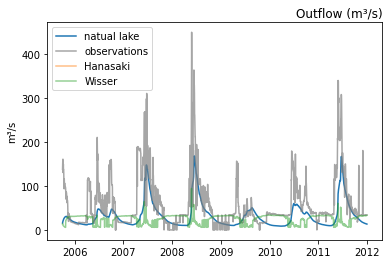

In [25]:
plt.plot(release_monthly_lake)
plt.plot(outflow_obs[start_date:], color='gray', alpha=0.7)
plt.plot(release_monthly, alpha=0.5)
plt.plot(release_monthly_wisser, alpha=0.5)

plt.title('Outflow (m³/s)', loc='right')
plt.ylabel('m³/s')

plt.legend(['natual lake', 'observations','Hanasaki', 'Wisser']);

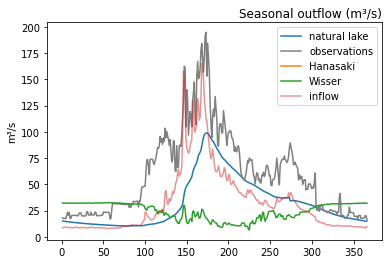

In [26]:

## determine start of operational year for each calendar year
# when monthly inflow drops below average annual inflow
plt.plot(release_monthly_lake.groupby(release_monthly_lake.index.dayofyear).mean())
plt.plot(outflow_obs[start_date:].groupby(release_monthly_lake.index.dayofyear).mean(), color='gray')
plt.plot(release_monthly.groupby(release_monthly_lake.index.dayofyear).mean())
plt.plot(release_monthly_wisser.groupby(release_monthly_lake.index.dayofyear).mean())

plt.plot(inflow.groupby(release_monthly_lake.index.dayofyear).mean(), alpha=0.5)
plt.ylabel('m³/s')
plt.title('Seasonal outflow (m³/s)', loc='right')
plt.legend(['natural lake', 'observations','Hanasaki','Wisser', 'inflow']);

In [27]:
# RMSE
def rmse(simulations,observations):
    return np.sqrt(((simulations - observations) ** 2).mean())

rmse_hanasaki = rmse(release_monthly,outflow_obs[start_date:])
rmse_natural_lake = rmse(release_monthly_lake,outflow_obs[start_date:])
rmse_wisser = rmse(release_monthly_wisser,outflow_obs[start_date:])

print("RMSE outflow natural lake: %0.2f" %rmse_natural_lake)
print("RMSE outflow hanasaki: %0.2f" %rmse_hanasaki)
print("RMSE outflow wisser: %0.2f" %rmse_wisser)


RMSE outflow natural lake: 49.52
RMSE outflow hanasaki: 55.06
RMSE outflow wisser: 69.85


### Plot resulting storage

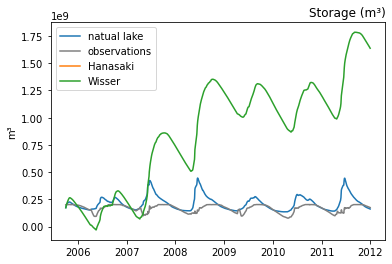

In [28]:
# storage
plt.plot(storage_lake)
plt.plot(storage_obs[start_date:], color='gray')
plt.plot(storage)
plt.plot(storage_wisser)

plt.title('Storage (m³)', loc='right')
plt.ylabel('m³')

plt.legend(['natual lake', 'observations','Hanasaki', 'Wisser']);

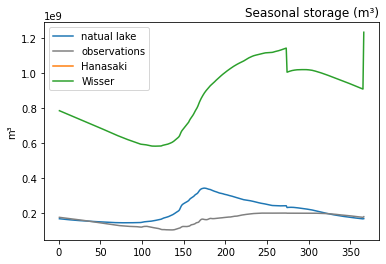

In [29]:
# seasonal cycle of storage
plt.plot(storage_lake.groupby(storage_lake.index.dayofyear).mean())
plt.plot(storage_obs[start_date:].groupby(storage_lake.index.dayofyear).mean(), color='gray')
plt.plot(storage.groupby(storage.index.dayofyear).mean())
plt.plot(storage_wisser.groupby(storage_wisser.index.dayofyear).mean())

plt.title('Seasonal storage (m³)', loc='right')
plt.ylabel('m³')


plt.legend(['natual lake', 'observations','Hanasaki', 'Wisser']);